# Task 2.2: Data Exploration by PCA and Clustering
## for Symptoms Data

Inspiration:
1. https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
2. Notebooks from COMP-551

Possibilities?
- https://towardsdatascience.com/using-k-means-clustering-for-image-segregation-fd80bea8412d

Notes:
- for NaN data, they are converted to = 0.0

## PCA & KMeans: Clustering Symptoms

We want to classify symptoms based on their weekly search trends over the 11 states

In [10]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from adjustText import adjust_text
import seaborn as sns

df = pd.read_csv('../Data/demedian_USA_coviddata_clean_25.csv')
symptoms = [key for key in df.keys() if 'symptom:' in key ]
data=np. array([])
for symptom in symptoms: 
    symptom_dat = np.reshape(df[symptom].values, (1,11*38))
    data = np.append(data,symptom_dat)
data= np.reshape(data,(len(symptoms),11*38))
data = np.nan_to_num(data)
data.shape

(91, 418)

### Step 1: Find Optimal Number of Components for PCA
The least number of components required to explain 95% of the data variance

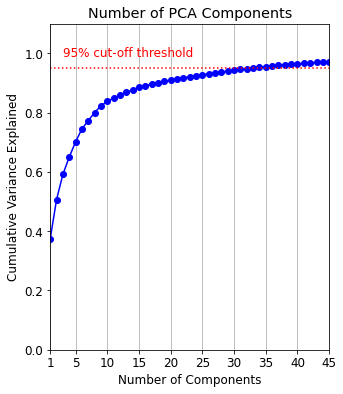

In [8]:
pca = PCA().fit(data)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,6)
fig, ax = plt.subplots()
xi = np.arange(1, 92, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='b')

plt.xlabel('Number of Components')
plt.xticks([1,5,10,15,20,25,30,35,40,45,50,55]) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative Variance Explained')
plt.title('Number of PCA Components')

plt.axhline(y=0.95, color='r', linestyle=':')
plt.text(3, 0.99, '95% cut-off threshold', color = 'red', fontsize=12)
plt.xlim(1,45)
ax.grid(axis='x')
plt.show()

We found that  11 components worked the best for the symptoms search trend data

### Step 2: Visualise PCA Reduced Data in 2-D

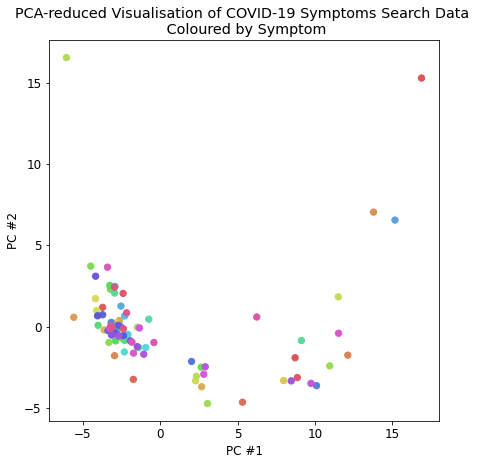

In [11]:
# A. Apply PCA: Reduce Dimensionality to X number of components
reduced_data = PCA(n_components=11).fit_transform(data)
plt.rcParams.update({'font.size': 12})

plt.rcParams["figure.figsize"] = (7,7)
colors =  sns.color_palette("hls", 91) #sns.cubehelix_palette(11).as_hex()
plt.scatter(reduced_data[:,0], reduced_data[:,1], color = colors, s = 40)
plt.rcParams["figure.figsize"] = (8,8)
plt.title('PCA-reduced Visualisation of COVID-19 Symptoms Search Data \n Coloured by Symptom')
plt.xticks()
plt.yticks()
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.show()

### Step 3: K-means Clustering of Data (Symptoms) based on Raw Data & PCA Reduced Data

In [14]:
def clustering(K, data, reduced_data):
    kmeans = KMeans(n_clusters=K, random_state=0)
    kmeans.fit(data)
    y_pred = kmeans.predict(data)

    kmeans_pca = KMeans(init='k-means++', n_clusters=K)
    kmeans_pca.fit(reduced_data)
    y_pred_pca = kmeans_pca.predict(reduced_data)
    return kmeans, y_pred, kmeans_pca, y_pred_pca

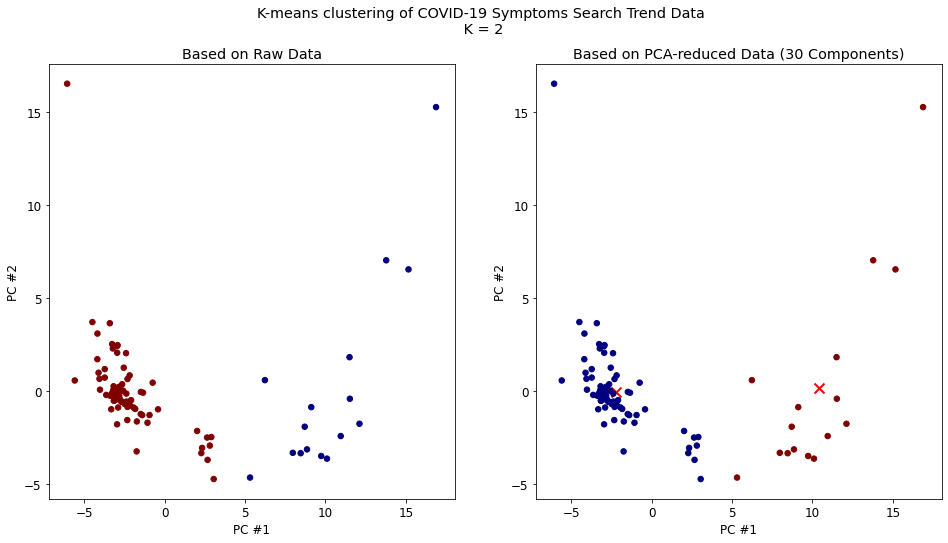

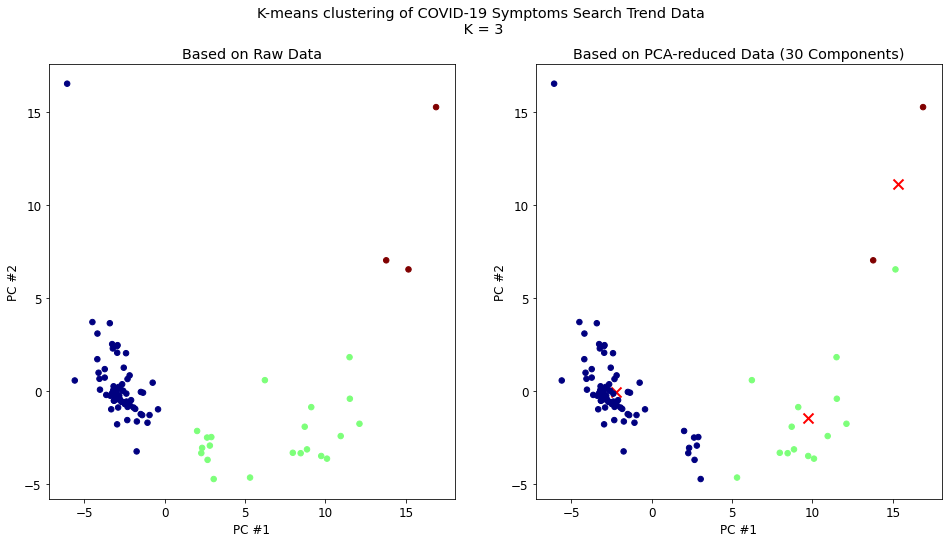

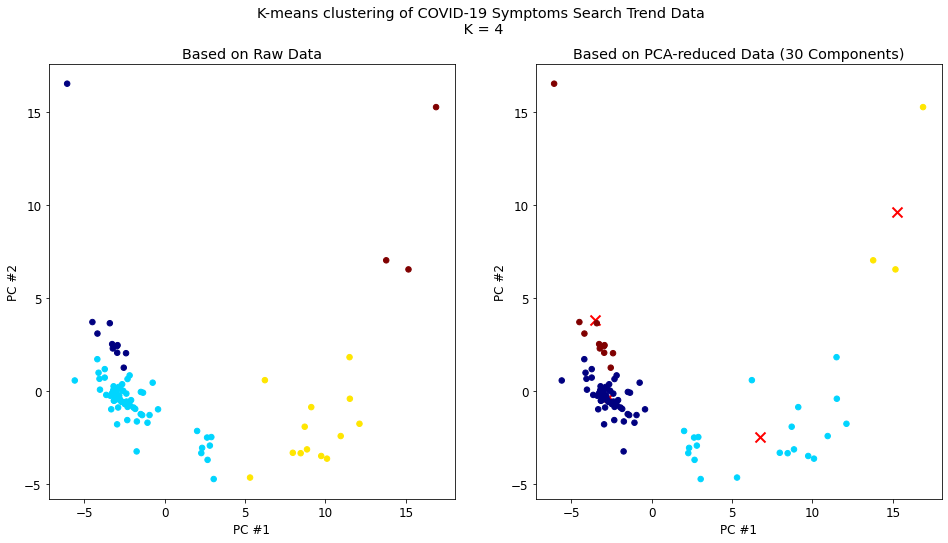

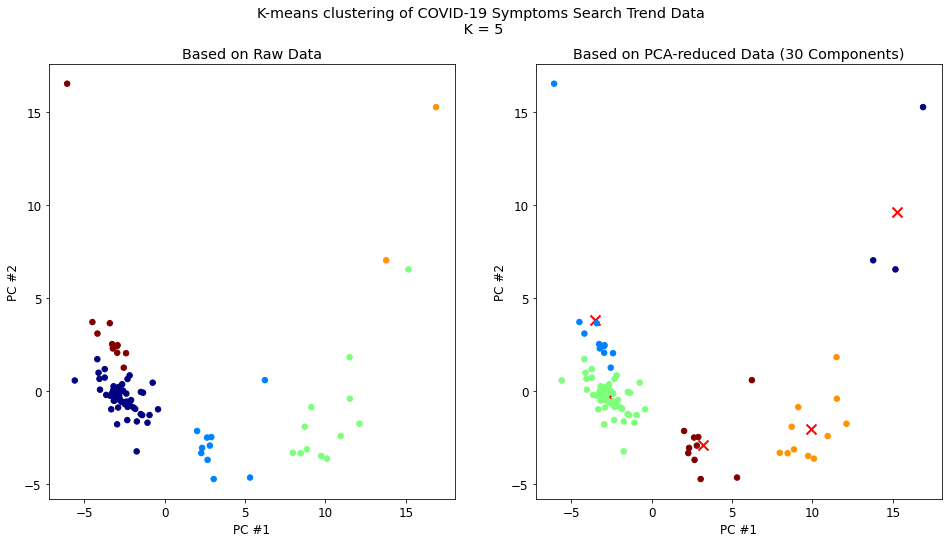

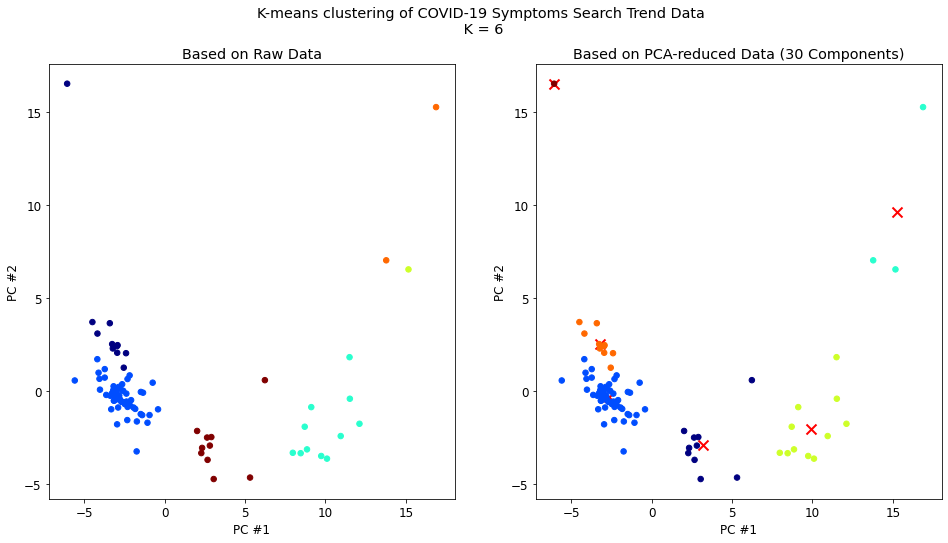

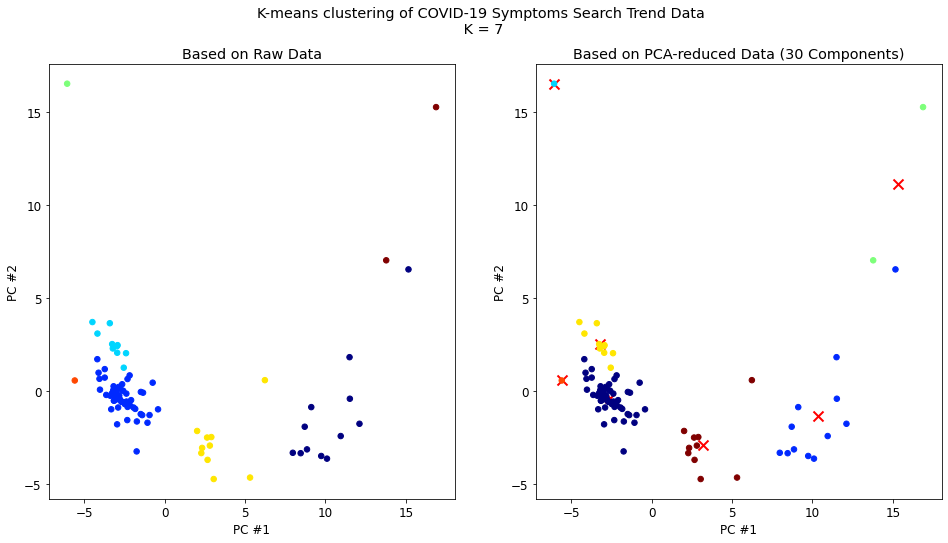

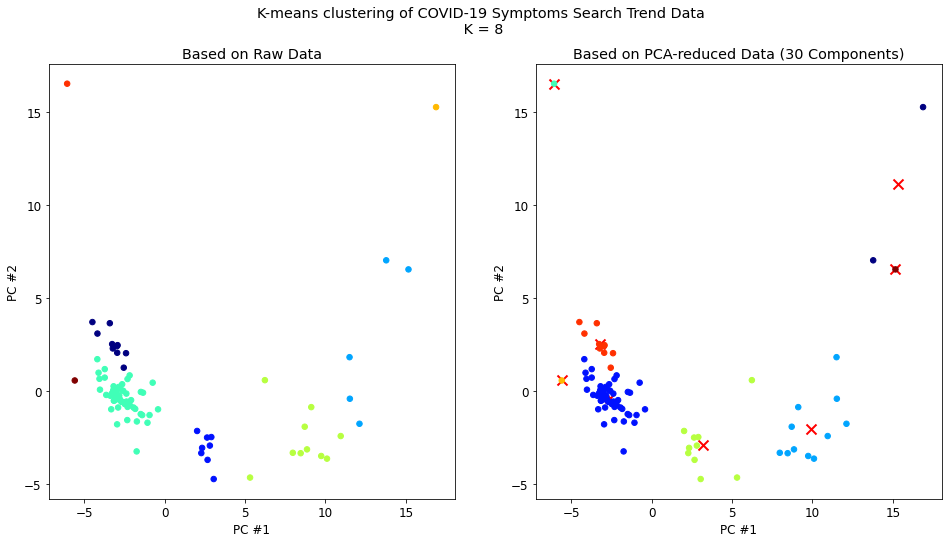

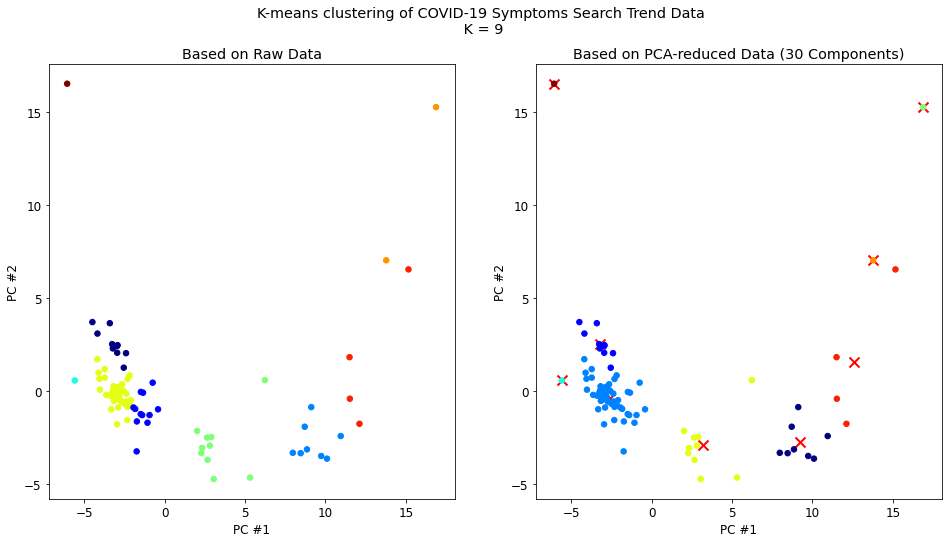

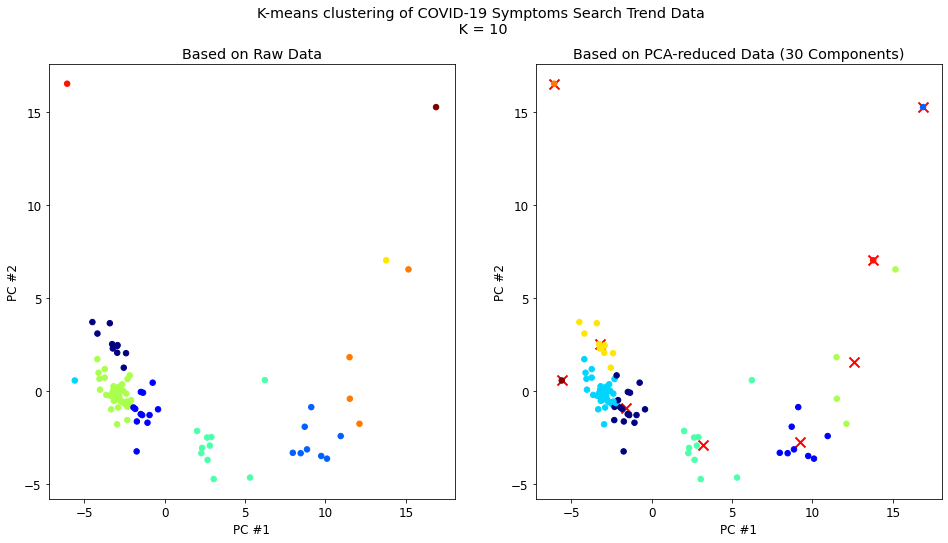

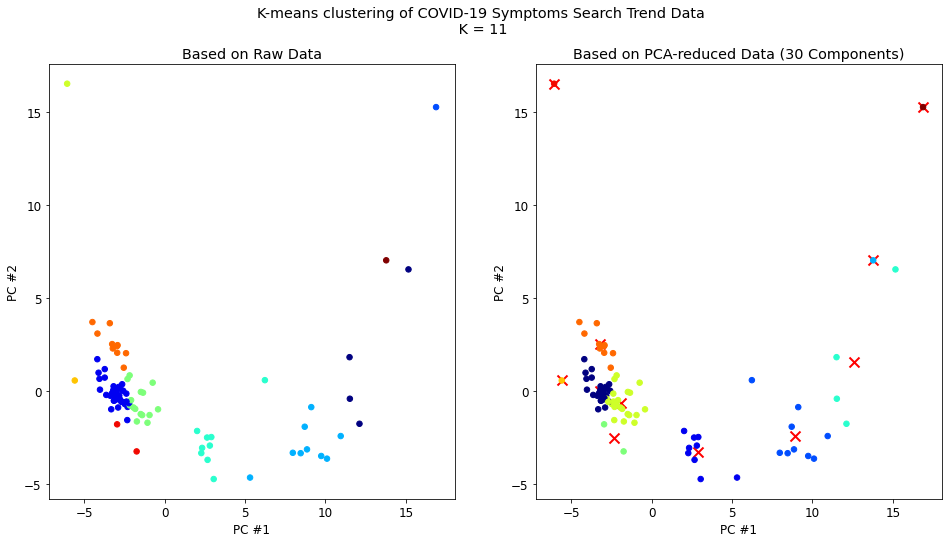

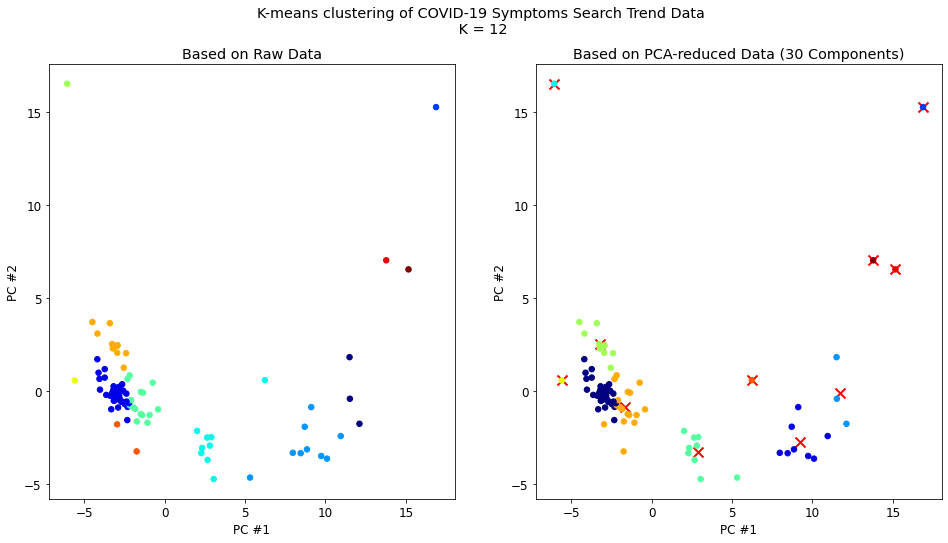

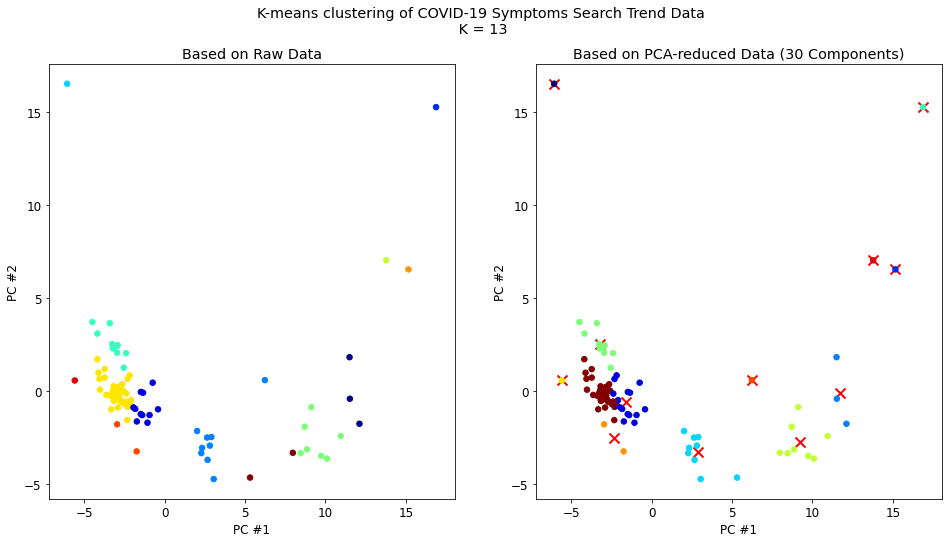

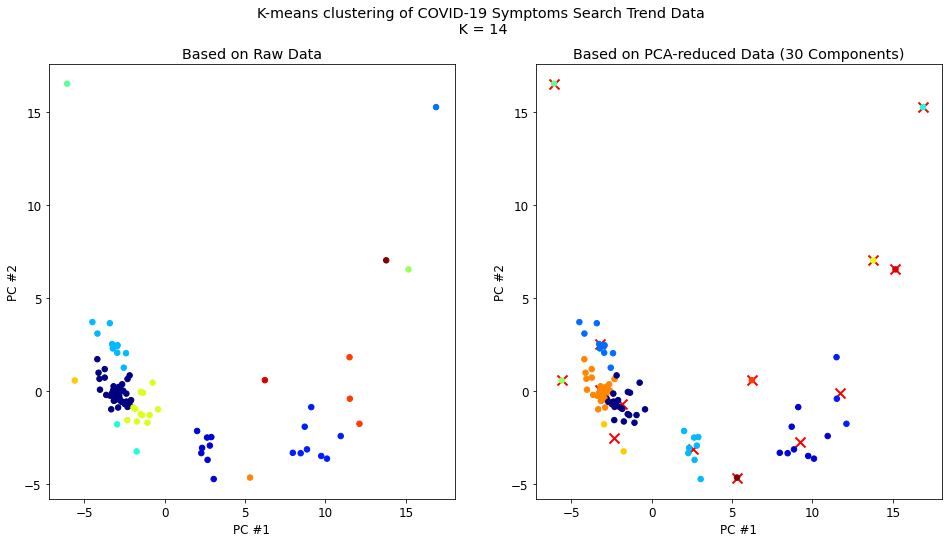

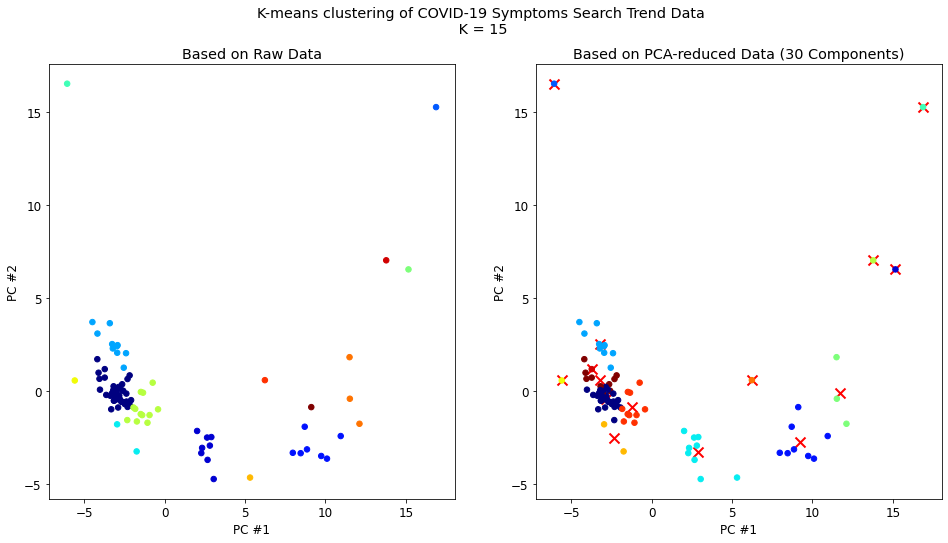

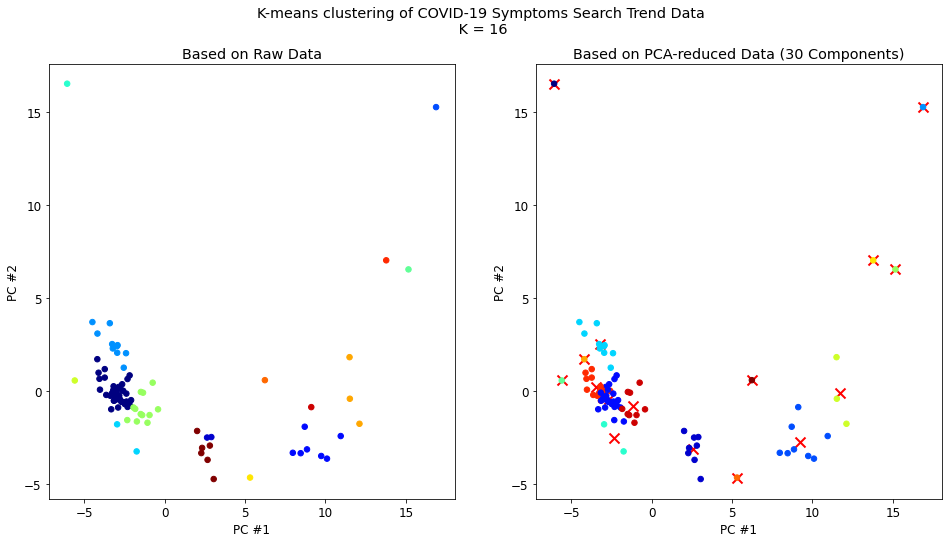

In [34]:
n_pca = 30 # number of componenets

for K in np.arange(2,17): # for a series of K (clusters)
    # A. Apply PCA: Reduce Dimensionality to X number of components
    reduced_data = PCA(n_components=n_pca).fit_transform(data)

    # B. Apply KMeans Clustering using both raw and reduced dataset
    kmeans, y_pred, kmeans_pca, y_pred_pca = clustering(K, data, reduced_data)

    # C. Visualise Results
    plt.rcParams["figure.figsize"] = (16,8)
    fig, ax = plt.subplots(1,2)
    ax[0].set_title('Based on Raw Data')
    preds = ax[0].scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_pred,s=30,cmap=plt.cm.get_cmap('jet'),zorder=1)
    ax[0].set_xlabel("PC #1")
    ax[0].set_ylabel("PC #2")

    ax[1].set_title('Based on PCA-reduced Data (30 Components)')
    preds = ax[1].scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_pred_pca,s=30,cmap=plt.cm.get_cmap('jet'),zorder=1)
    ## Plot the cluster centroids as a red X
    centroids = kmeans_pca.cluster_centers_
    ax[1].scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=100, linewidths=2,
                color='r', zorder=0)
    ax[1].set_xlabel("PC #1")
    ax[1].set_ylabel("PC #2")
    
    plt.suptitle('K-means clustering of COVID-19 Symptoms Search Trend Data\n K = '+str(K))
    plt.savefig('../Plots/'+str(K)+'_symptomclusters.png')
    plt.show()
    

### Step 4: Clean Up Final Plot

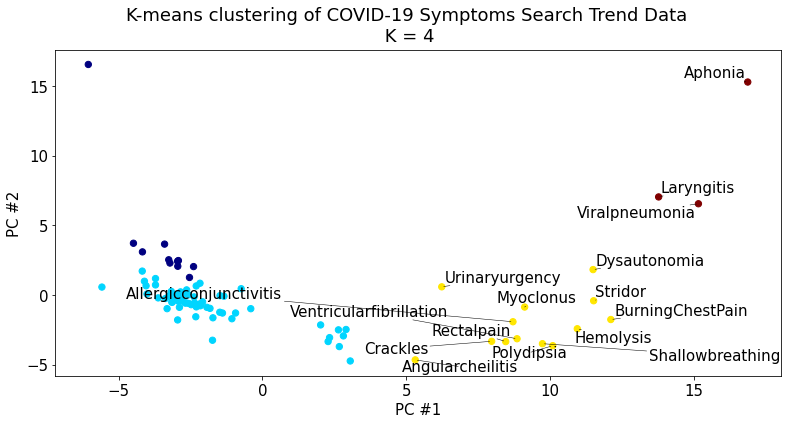

In [49]:
symptoms = [key for key in df.keys() if 'symptom:' in key ]
symptoms_np = np.array(symptoms)

# A. Apply PCA: Reduce Dimensionality to X number of components
reduced_data = PCA(n_components=30).fit_transform(data)
# B. Apply KMeans Clustering using both raw and reduced dataset
kmeans, y_pred, kmeans_pca, y_pred_pca = clustering(4, data, reduced_data)

# C. Visualise Results
plt.rcParams["figure.figsize"] = (13,6)
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots()
preds = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_pred,s=40,cmap=plt.cm.get_cmap('jet'),zorder=1)
ax.set_xlabel("PC #1")
ax.set_ylabel("PC #2")

texts = []
for cluster in [2,3]:
    labels = symptoms_np[y_pred ==cluster].tolist()
    labels_x = reduced_data[np.where(y_pred ==cluster), 0].tolist()[0]
    labels_y = reduced_data[np.where(y_pred ==cluster), 1].tolist()[0]

    for i, txt in enumerate(labels):
        label = txt.replace('symptom:', '').replace(" ",'')
        texts.append(ax.text(labels_x[i-1], labels_y[i-1],label, size = 15))
        
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
plt.suptitle('K-means clustering of COVID-19 Symptoms Search Trend Data\n K = '+str(4))
#plt.savefig('../Plots/'+str(K)+'_symptomclusters.png')
plt.show()

In [39]:
symptoms_np[7]

'symptom:Asphyxia'

In [40]:
y_pred[7]

1

### Explore Clustering Results: Plot The Datasets in Each Cluster

4


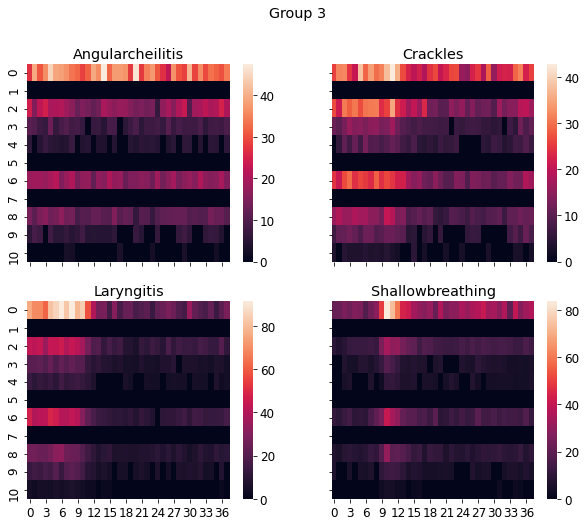

In [761]:
import seaborn as sns

label = 3
print(str((y_pred_high==label).sum()))
idx = np.where(y_pred_high == label)[0]

fig,axn = plt.subplots(2, 2, figsize = (10,8),sharex=True, sharey=True)
fig.suptitle('Group '+str(label))
count = 0
for ax in axn.flat:
    sns.heatmap(np.reshape(data[idx[count]], (11,38)), ax=ax)
    name = symptoms[idx[count]].replace('symptom:', '').replace(" ",'')
    ax.set_title(name)
    count +=1

## Other Ways of Sorting Data

In [413]:
import numpy as np
import pandas as pd

df = pd.read_csv('../Data/USA_coviddata_clean_25.csv')
symptoms = [key for key in df.keys() if 'symptom:' in key ]
data=np. array([])
for symptom in symptoms: 
    symptom_dat = np.reshape(df[symptom].values, (1,11*38))
    data = np.append(data,symptom_dat)
    
data= np.reshape(data,(len(symptoms),11*38))
data = np.nan_to_num(data) # fillNA with 0

In [510]:
# ### Extract Data By Region
# region = 4
# cut_data = data[:,(region-1)*38:region*38]

### or ALL DATA
cut_data = data

### or ALL STATES but weighted average
symptoms = [key for key in df.keys() if 'symptom:' in key ]
df_mean = pd.DataFrame(columns=df.columns[3:])

for date in df.date.unique(): # for every day
    mean = df[df.date == date].sum()
    mean = mean[1:]
    mean['date']= date
    df_mean = df_mean.append(mean,ignore_index=True)

symptoms = [key for key in df.keys() if 'symptom:' in key ]
cut_data=np. array([])
for symptom in symptoms: 
    symptom_dat = np.reshape(df_mean[symptom].values, (1,38))
    cut_data = np.append(cut_data,symptom_dat)
    
cut_data = np.reshape(cut_data,(len(symptoms),1*38))
cut_data = np.nan_to_num(cut_data)

In [511]:
# ### Standardise Data (Normalise by Mean of Each Feature)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(cut_data.T)
# print(scaler.data_max_)
# print("Number of Features: "+str(scaler.data_max_.shape[0]))
# finaldata = scaler.fit_transform(cut_data.T).T
# finaldata.shape


## or NO Standardisation
finaldata = cut_data 